In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp, odeint
import scipy.optimize as opt

In [9]:
#making a first order CSTR for E. Coli decay

In [2]:
Ea = 84900
R = 8.314
k0 = 2.83e13
def ktemp(T):
    return k0 * np.exp(-Ea / (R * T))

In [3]:
def knatural(T): #this is just natural decay
    k_nat = 0.37 #1/day
    Tref = 293 #K
    thetan = 0.951
    knatT = k_nat * (thetan**(T-Tref))
    return knatT/(24*60)

In [4]:
def ksolar(I, T): #how UV impacts decay
    k_sol = 1.8
    thetas = 1
    Tref = 293
    Icon = I*(86400/1e6)
    ksT = k_sol*(thetas**(T-Tref))
    ksolday = ksT*Icon
    return ksolday/(24*60)

In [5]:
def kpred(D,T): #filter feeders
    kp = 0.020
    thetap = 1
    Tref = 293
    kpT = kp*(thetap**(T-Tref))
    kpday = kpT*D
    return kpday /(24*60)

In [6]:
def cstrall(c, t, Q, V, c0, T, Isol, Ddap):
    knat = knatural(T)
    ksol = ksolar(Isol, T)
    kpr = kpred(Ddap, T)
    
    ktot = knat + ksol + kpr
    
    dcdt = (Q/V)*(c0-c) - ktot*c
    return dcdt

#initial parameters
V = 1000 
Q = 10 
c0 = 1.7e6
T = 298 #initial values from paper Hernandez-Crespo
Isol = 800
Ddap = 10

tau = V/Q
knat = knatural(T)
ksol = ksolar(Isol, T)
kpr = kpred(Ddap, T)
ktot = knat + ksol + kpr

c_ss = c0 / (1 + ktot * tau)

In [7]:
time = np.linspace(0, 300, 100)
cinit = 0
csol = odeint(cstrall, cinit, time, args=(Q,V,c0,T,Isol, Ddap))

Text(0, 0.5, 'concentration')

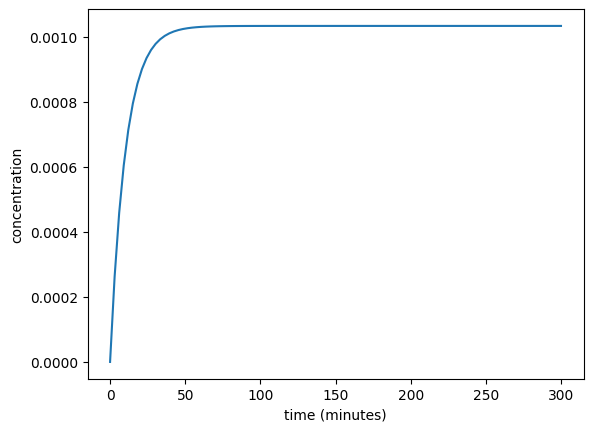

In [8]:
plt.plot(time, csol/(c0*100))
plt.xlabel('time (minutes)')
plt.ylabel('concentration')

In [ ]:
# Objective 

# Objective 

To develop and analyze a computational model of E. coli removal in a wastewater pond that predicts how concentration changes over time, determines whether and when effluent meets a chosen safety threshold, and identifies which design and operating parameters most strongly control this performance.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit  

%matplotlib inline


In [2]:
# --- 1) Random initial bacteria count ---
# Choose a random starting contamination level for the pond.
# (avoid 0 so the math makes sense)
bacteria0 = np.random.randint(50, 200)   # e.g. between 50 and 199
end_time  = 100.0   # simulate 0 to 100 days

max_steps = 200000  # safety cap on number of events

# --- 2) Randomize k_death based on initial bacteria count ---
# If bacteria count > 100  -> pick k_death from [0.5, 0.8]
# If bacteria count <= 100 -> pick k_death from [0.1, 0.5]

if bacteria0 > 100:
    k_death = np.random.uniform(0.5, 0.8)
    death_regime = "high-density (bacteria > 100), k_death from 0.5–0.8"
else:
    k_death = np.random.uniform(0.1, 0.5)
    death_regime = "low-density (bacteria ≤ 100), k_death from 0.1–0.5"

# --- 3) Randomize k_wash based on a random season ---
# season = 0 -> winter : very low washout (fixed 0.1)
# season = 1 -> spring : high washout (0.5–0.8)
# season = 2 -> summer : high washout (0.5–0.8)
# season = 3 -> autumn : medium washout (fixed 0.2)

season_code = np.random.randint(0, 4)  # 0, 1, 2, or 3

if season_code == 0:
    season_name = "winter"
    k_wash = 0.1
elif season_code == 1:
    season_name = "spring"
    k_wash = np.random.uniform(0.5, 0.8)
elif season_code == 2:
    season_name = "summer"
    k_wash = np.random.uniform(0.5, 0.8)
else:  # season_code == 3
    season_name = "autumn"
    k_wash = 0.2

# --- 4) Choose k_in so that we get DECAY (bacteria0 > N_ss) ---
# Condition for decay: k_in < bacteria0 * (k_death + k_wash)
removal_sum = k_death + k_wash
k_in_max_for_decay = bacteria0 * removal_sum    # if k_in is below this, N0 > N_ss

# pick k_in as some random fraction of that max (e.g. 20%–80% of it)
k_in = np.random.uniform(0.2 * k_in_max_for_decay, 0.8 * k_in_max_for_decay)

# compute the resulting approximate steady state (for info)
N_ss_est = k_in / removal_sum

# --- 5) Print out what we sampled this time ---
print("Initial bacteria:", bacteria0, "| k_death:", round(k_death, 3), "1/day")
print("  (death regime:", death_regime + ")")
print("Season:", season_name, f"(code = {season_code})", "| k_wash:", round(k_wash, 3), "1/day")
print("k_in:", round(k_in, 3), "bacteria/day")


Initial bacteria: 186 | k_death: 0.519 1/day
  (death regime: high-density (bacteria > 100), k_death from 0.5–0.8)
Season: summer (code = 2) | k_wash: 0.56 1/day
k_in: 84.671 bacteria/day


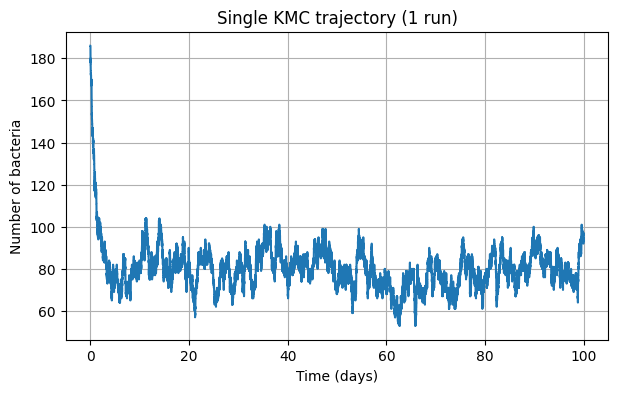

In [3]:
def kmc_one_run(bacteria0, end_time, k_in, k_death, k_wash, max_steps=200000):
    """
    Simulate ONE KMC trajectory for the pond.

    State variable:
        bacteria (integer) = current number of bacteria in pond

    Events and rates:
        0: inflow   -> bacteria += 1   (rate_in    = k_in)
        1: death    -> bacteria -= 1   (rate_death = k_death * bacteria)
        2: washout  -> bacteria -= 1   (rate_wash  = k_wash  * bacteria)
    """
    time = 0.0
    bacteria = bacteria0

    times = [time]
    bacteria_list = [bacteria]

    steps = 0
    while time < end_time and bacteria > 0 and steps < max_steps:
        # 1) compute event rates
        rate_in    = k_in
        rate_death = k_death * bacteria
        rate_wash  = k_wash  * bacteria

        rates = np.array([rate_in, rate_death, rate_wash])
        cumulative_rates = rates.cumsum()
        total_rate = cumulative_rates[-1]

        if total_rate == 0:
            break  # no more events can occur

        # 2) choose which event happens
        u = np.random.uniform(0, 1)
        for event_index, cum_rate in enumerate(cumulative_rates):
            if cum_rate > u * total_rate:
                event = event_index
                break

        # 3) update bacteria according to event
        if event == 0:            # inflow
            bacteria += 1
        elif event == 1:          # death
            bacteria -= 1
        elif event == 2:          # washout
            bacteria -= 1
        else:
            raise ValueError("event index must be 0, 1, or 2")

        if bacteria < 0:
            bacteria = 0

        # 4) draw time step (exponential waiting time)
        u_dt = np.random.uniform(0, 1)
        dt = -np.log(u_dt) / total_rate
        time += dt

        # 5) store state
        times.append(time)
        bacteria_list.append(bacteria)

        steps += 1

    return np.array(times), np.array(bacteria_list)

# ---- run ONE trajectory and plot it ----
np.random.seed(0)  # for repeatability
times_1, bact_1 = kmc_one_run(bacteria0, end_time, k_in, k_death, k_wash, max_steps)

plt.figure(figsize=(7,4))
plt.step(times_1, bact_1, where="post", color="tab:blue")
plt.xlabel("Time (days)")
plt.ylabel("Number of bacteria")
plt.title("Single KMC trajectory (1 run)")
plt.grid(True)
plt.show()


Number of runs: 3
k_tot (k_death + k_wash) = 0.703 1/day
Estimated steady level N_ss = 57.70
R^2 (mean of 3 runs vs theory) = 0.7894


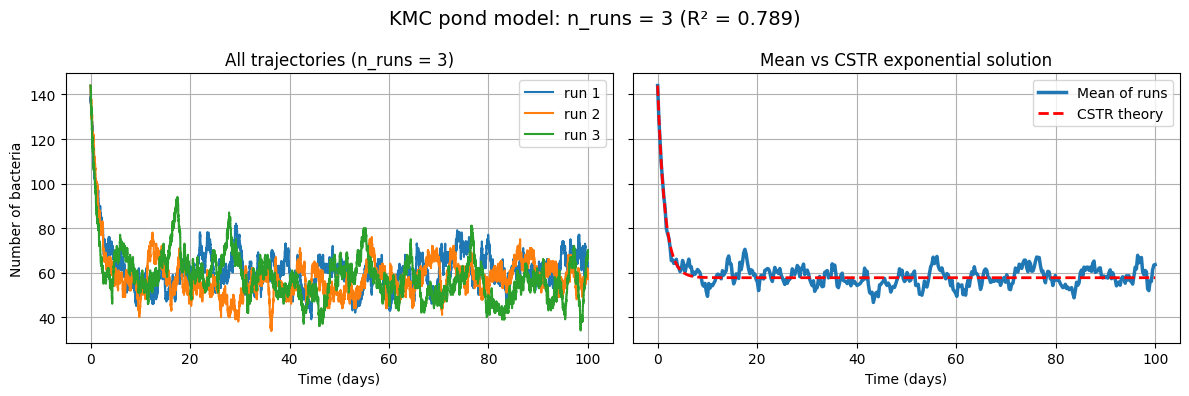


Number of runs: 5
k_tot (k_death + k_wash) = 0.703 1/day
Estimated steady level N_ss = 57.70
R^2 (mean of 5 runs vs theory) = 0.8153


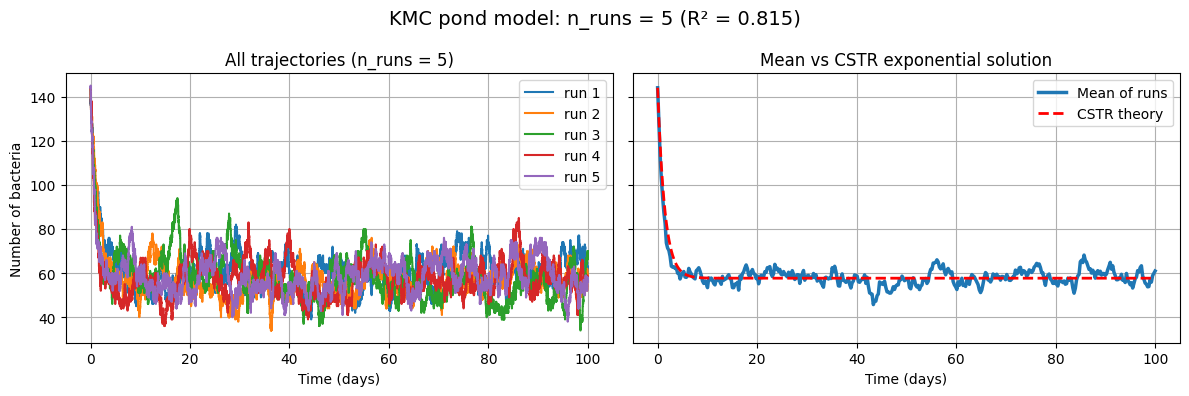


Number of runs: 10
k_tot (k_death + k_wash) = 0.703 1/day
Estimated steady level N_ss = 57.70
R^2 (mean of 10 runs vs theory) = 0.9064


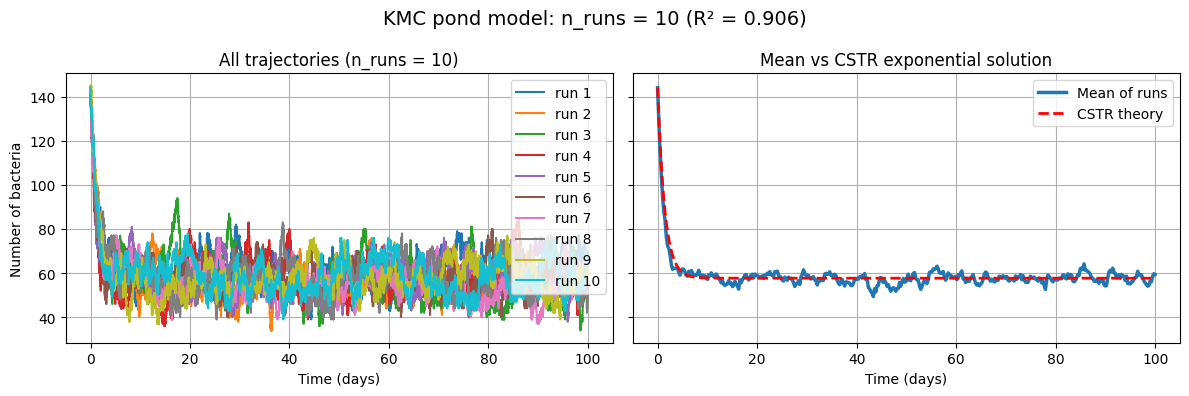

In [23]:
# Cell: compare mean KMC to exponential CSTR solution for 3, 5, and 10 runs

runs_list = [3, 5, 10]

for n_runs in runs_list:
    print("\n==============================")
    print("Number of runs:", n_runs)

    np.random.seed(0)  # so each n_runs is comparable

    # ----- 1) simulate n_runs trajectories -----
    all_times = []
    all_bact  = []

    for r in range(n_runs):
        times_run, bact_run = kmc_one_run(
            bacteria0, end_time, k_in, k_death, k_wash, max_steps
        )
        all_times.append(times_run)
        all_bact.append(bact_run)

    # ----- 2) build common time grid and mean trajectory -----
    t_grid = np.linspace(0, end_time, 400)
    all_interp = np.zeros((n_runs, len(t_grid)))

    for r in range(n_runs):
        all_interp[r, :] = np.interp(t_grid, all_times[r], all_bact[r])

    mean_N = all_interp.mean(axis=0)

    # ----- 3) theoretical exponential CSTR solution -----
    # k_tot is the total removal rate (lambda)
    k_tot = k_death + k_wash
    N_ss  = k_in / k_tot

    N_theory = N_ss + (bacteria0 - N_ss) * np.exp(-k_tot * t_grid)

    # ----- 4) compute R^2 between mean_N and N_theory -----
    ss_res = np.sum((mean_N - N_theory)**2)
    ss_tot = np.sum((mean_N - mean_N.mean())**2)
    R2 = 1 - ss_res / ss_tot

    print(f"k_tot (k_death + k_wash) = {k_tot:.3f} 1/day")
    print(f"Estimated steady level N_ss = {N_ss:.2f}")
    print(f"R^2 (mean of {n_runs} runs vs theory) = {R2:.4f}")

    # ----- 5) plotting: left = all runs, right = mean vs theory -----
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
    ax_left, ax_right = axes

    # left: individual trajectories
    ax_left.set_title(f"All trajectories (n_runs = {n_runs})")
    for r in range(n_runs):
        ax_left.step(all_times[r], all_bact[r], where="post", label=f"run {r+1}")
    ax_left.set_xlabel("Time (days)")
    ax_left.set_ylabel("Number of bacteria")
    ax_left.grid(True)
    if n_runs <= 10:
        ax_left.legend()

    # right: mean and theoretical exponential CSTR curve
    ax_right.set_title("Mean vs CSTR exponential solution")
    ax_right.plot(t_grid, mean_N, label="Mean of runs", linewidth=2.5)
    ax_right.plot(t_grid, N_theory, "r--", label="CSTR theory", linewidth=2)
    ax_right.set_xlabel("Time (days)")
    ax_right.grid(True)
    ax_right.legend()

    fig.suptitle(f"KMC pond model: n_runs = {n_runs} (R² = {R2:.3f})", fontsize=14)
    plt.tight_layout()
    plt.show()
